# L1 Regularization

### Imports

In [1]:
from __future__ import print_function
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os


from art.classifiers import PyTorchClassifier
from art.utils import load_cifar10
from art.utils import load_dataset


%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset

In [2]:
# Read CIFAR10 dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=128)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)
test_dataloader_single = DataLoader(test_dataset, batch_size=1)

### Inputs

In [49]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
path = Path("C:/Users/Matach/Documents/Imperial College London/FYP/saved_models/CIFAR10/FGSM/vanilla")
file = "l1_regularized_1e-05_model_1_e15.pth"
file = "model_04_e20.pth"
pretrained_model = os.path.join(path, file)
use_cuda = True

## Model

In [50]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Model().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
Model(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.05, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dr

## FGSM

In [51]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        target = torch.argmax(target, axis=1) # required for matching shapes

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = data.grad.data
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [52]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_dataloader_single, eps)
    accuracies.append(acc)
    examples.append(ex)
print(accuracies)

Epsilon: 0	Test Accuracy = 7872 / 10000 = 0.7872
Epsilon: 0.05	Test Accuracy = 3739 / 10000 = 0.3739
Epsilon: 0.1	Test Accuracy = 2738 / 10000 = 0.2738
Epsilon: 0.15	Test Accuracy = 2053 / 10000 = 0.2053
Epsilon: 0.2	Test Accuracy = 1631 / 10000 = 0.1631
Epsilon: 0.25	Test Accuracy = 1390 / 10000 = 0.139
Epsilon: 0.3	Test Accuracy = 1262 / 10000 = 0.1262
[0.7872, 0.3739, 0.2738, 0.2053, 0.1631, 0.139, 0.1262]


In [54]:
a = np.mean([
[0.7961, 0.3956, 0.3276, 0.2726, 0.2341, 0.2065, 0.183],
[0.7872, 0.3739, 0.2738, 0.2053, 0.1631, 0.139, 0.1262]

], axis=0)
a

array([0.79165, 0.38475, 0.3007 , 0.23895, 0.1986 , 0.17275, 0.1546 ])

In [59]:
data = {
    0: [0.79165, 0.38475, 0.3007 , 0.23895, 0.1986 , 0.17275, 0.1546 ],
    '1e-01': [0.79285, 0.36425, 0.27345, 0.21415, 0.1766 , 0.15115, 0.137  ],
    '1e-02': [0.78845, 0.37105, 0.29195, 0.22965, 0.1894 , 0.16375, 0.14725],
    '1e-03': [0.79145, 0.3581 , 0.2613 , 0.204  , 0.17215, 0.15425, 0.14105],
    '1e-04': [0.7863 , 0.3758 , 0.29375, 0.23215, 0.1954 , 0.1694 , 0.15425],
    '1e-05': [0.79165, 0.364  , 0.2833 , 0.2277 , 0.19595, 0.1751 , 0.16395],
}

In [ ]:
[0.7949, 0.3382, 0.2641, 0.209, 0.1756, 0.1547, 0.143],
[0.7908, 0.3903, 0.2828, 0.2193, 0.1776, 0.1476, 0.131]

[0.7943, 0.4265, 0.3496, 0.2791, 0.2335, 0.207, 0.1854],
[0.7826, 0.3156, 0.2343, 0.1802, 0.1453, 0.1205, 0.1091]

[0.7862, 0.3422, 0.238, 0.1773, 0.1443, 0.1282, 0.1139],
[0.7967, 0.374, 0.2846, 0.2307, 0.2, 0.1803, 0.1682]

[0.7776, 0.3698, 0.3034, 0.2326, 0.1893, 0.1614, 0.1477],
[0.795, 0.3818, 0.2841, 0.2317, 0.2015, 0.1774, 0.1608]

[0.7878, 0.4222, 0.3456, 0.2777, 0.2372, 0.2096, 0.1913],
[0.7955, 0.3058, 0.221, 0.1777, 0.1547, 0.1406, 0.1366]


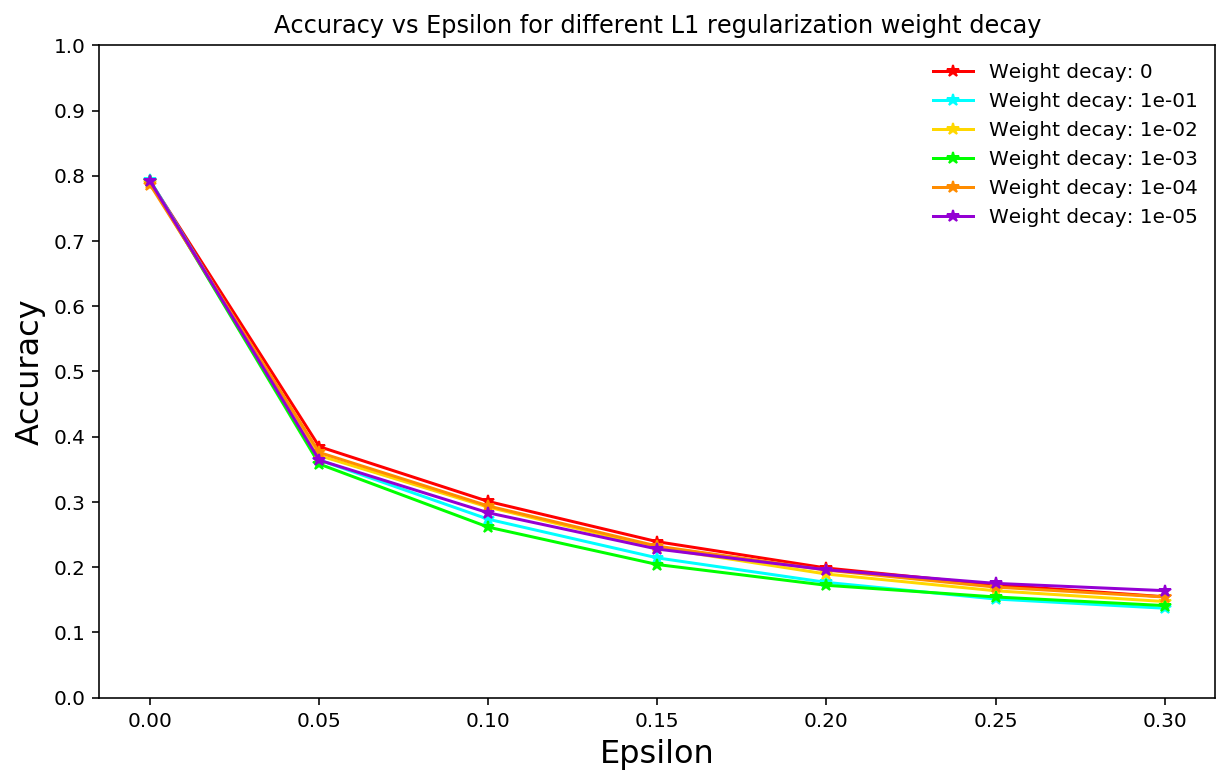

In [60]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))
colors =  ['red', 'aqua', 'gold', 'lime', 'darkorange', 'darkviolet']

for idx, (decay, results) in enumerate(data.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label="Weight decay: {}".format(decay))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon for different L1 regularization weight decay")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()